In [1]:
from sklearn.ensemble import IsolationForest

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [8]:
#get unique values and counts of each value
unique, counts = np.unique(y_train, return_counts=True)
cont_train = counts[1] / counts[0]

In [15]:
# Custom recall function for supervised evaluation
def custom_recall(y_true, y_pred):
    # Isolation Forest: -1 = anomaly (mapped to 1), 1 = normal (mapped to 0)
    y_pred_mapped = np.where(y_pred == -1, 1, 0)
    return recall_score(y_true, y_pred_mapped, pos_label=1)

# Create custom scorer using recall
recall_scorer = make_scorer(custom_recall, greater_is_better=True)

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200, 400, 700, 800, 1000, 1200],
    'max_samples': ['auto', 0.1, 0.4, 0.6, 0.8],
    'contamination': ['auto',0.1, cont_train, 0.4],
    'max_features': [0.7, 0.6, 0.55],
}

iso_forest = IsolationForest(
    random_state=42,
    verbose=0,
    warm_start=True  # Can be disabled to save memory but didn't cause issues
)

grid_search = GridSearchCV(
    estimator=iso_forest,
    param_grid=param_grid,
    scoring=recall_scorer,
    cv=5,  # Cross validation value can be increased
    n_jobs=-1,  # Runs sequentially
    verbose=3,
    pre_dispatch='2*n_jobs',  # Control memory usage
    error_score='raise'
)

print("Starting grid search...")
grid_search.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best Recall score: {grid_search.best_score_:.4f}")
#the output is recall not f1 but need a lot of time to run again to prin recall score

Starting grid search...
Fitting 5 folds for each of 360 candidates, totalling 1800 fits

Best parameters found:
{'contamination': 0.4, 'max_features': 0.6, 'max_samples': 0.4, 'n_estimators': 700}
Best F1 score: 0.4290


In [16]:
best_model = grid_search.best_estimator_
y_pred_if = best_model.predict(X_test)
y_pred = np.where(y_pred_if == -1, 0, 1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nEvaluation Metrics with Best Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")



Evaluation Metrics with Best Model:
Accuracy: 0.4322
Precision: 0.2145
Recall: 0.5726
F1-Score: 0.3121


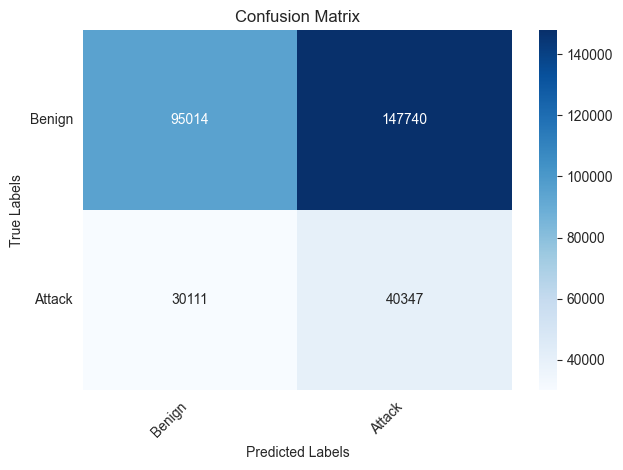

In [17]:
####NOTE####
#the confusion matrix is inverted because the labels are inverted in the dataset
#so the correct matrix is:
#147740,95014
#40347, 30111
############


labels = [
    'Benign',
    'Attack'
]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()